In [1]:
# First let's import our libraries of focus
import eia
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import requests
import numpy as np
from datetime import datetime
from datetime import date
import matplotlib.ticker as ticker
import resample
from dateutil.relativedelta import relativedelta
import plotly.express as px
%matplotlib inline

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.stattools import acf
#import jupyterthemes

# Forecasting Exxon's (XOM) Stock Price with VAR (Vector Autoregression)

#### "All models are wrong but some are useful" - George E. P. Box


<br>
<br>Here we present a novel way to predict the price of Exxon's stock (XOM) in a short term horizon (days or weeks).
<br>
<br>VAR (Vetor Autoregression) is a model that comes in very useful when trying to predict time series data while also wanting to learn something from adjacent time series.
<br>
<br>The way it works, is that it gathers information from its own time series attributes (in this case our stock), while learning from the time series attributes of other time series data, in this case, data we hypothesize influences the stock price.
<br>
<br>We will define such variables/time series as follows:
<br>- XOM Price: The Exxon stock price
<br>- S&P 500: The S&P 500 stock market index
<br>- WTI Price: The price of the West Texas Intermediate (US) crude oil barrel
<br>- Brent Price: The price of the Brent (EU) crude oil barrel
<br>- Production: US crude oil production
<br>- Consumption: US consumption of oil products
<br>- Inventory (Crude): US crude oil inventory
<br>- Input to Refineries: US refiner crude oil consumption
<br>- Inventory (Gas): US inventory of gasoline
<br>
<br>Let's first gather the financial (price) data from Yahoo Finance

In [2]:
# Next, let's get financial data from Yahoo Finance
xom = yf.Ticker("XOM")
sp500 = yf.Ticker("^GSPC")
bre = yf.Ticker("BZ=F") 
wt = yf.Ticker("CL=F")

In [3]:
# Now, let's get their daily closing price and package them together
histxom = xom.history(period="max")
histsp = sp500.history(period="max")
histbre = bre.history(period="max")
histwt = wt.history(period="max")
exxon = histxom.drop(columns = ['Open', 'High', 'Low', 'Volume', 'Dividends', 'Stock Splits'])
exxon = exxon.rename(columns={'Close': 'XOM Price'})
market = histsp.drop(columns = ['Open', 'High', 'Low', 'Volume', 'Dividends', 'Stock Splits'])
market = market.rename(columns={'Close': 'S&P 500'})
brent = histbre.drop(columns = ['Open', 'High', 'Low', 'Volume', 'Dividends', 'Stock Splits'])
brent = brent.rename(columns={'Close': 'Brent Price'})
wti = histwt.drop(columns = ['Open', 'High', 'Low', 'Volume', 'Dividends', 'Stock Splits'])
wti = wti.rename(columns={'Close': 'WTI Price'})
fin = pd.concat([exxon,market,brent,wti], axis = 1)

In [4]:
# Time to get crude oil data from EIA; let's use our API Key 
api_key = 'QVz5PaUgJZM1zgMo3NoOpqmmsNsfcQGKvLSq1ZdV'

In [5]:
# Let's label columns
titles = ['Production',
#           'WTI Price',
#           'Brent Price',
#           'Exports',
#           'Imports',
          'Consumption',
          'Inventory (Crude)',
          'Input to Refineries',
          'Inventory (Gas)']
# Now let's type the corresponding dataset codes from EIA
codes = ['PET.MCRFPUS2.M',
#          'PET.RWTC.D',
#          'PET.RBRTE.D',
#          'PET.WTTEXUS2.W',
#          'PET.WTTIMUS2.W',
         'PET.WRPUPUS2.W',
         'PET.WTTSTUS1.W',
         'PET.WCRRIUS2.W',
         'PET.WGTSTUS1.W']
# This is where we will store the data first 
eia_dat = []

In [6]:
# Let's pull in data via EIA API
for i in range(len(codes)):
    url = 'https://api.eia.gov/series/?api_key=' + api_key + '&series_id=' + codes[i]
    r = requests.get(url)
    json_data = r.json()
        
    if r.status_code == 200:
        print('Success!')
    else:
        print('Error')
    
    df = pd.DataFrame(json_data.get('series')[0].get('data'),
                      columns = ['Date', titles[i]])
    df.set_index('Date', drop=True, inplace=True)
    eia_dat.append(df)

Success!
Success!
Success!
Success!
Success!


In [7]:
# Let's get the latest date available for XOM stock price
endDate = max(fin.index)

In [8]:
# First, let's convert de finance data into a ts set
mask = (fin.index <= endDate)
fin = fin.loc[mask]
fin = fin.resample('D', origin = 'end_day').mean()
fin = fin.ffill()
fin.columns.name = fin.index.name
fin.index.name = None

# Now, let's do the same for the production data and concatenate it to the finance data
prod = eia_dat[0]
prod = prod.reindex(index=prod.index[::-1])
prod.reset_index(inplace=True)
prod['Date'] = list(map(lambda x: datetime.strptime(x,'%Y%m').strftime('%Y-%m-%d'), prod['Date']))
lastval = prod.iloc[:,1].iat[-1]
last = pd.DataFrame(columns=['Date', 'Production'])
last.loc[0] = [endDate, lastval]
prod = pd.concat([prod, last]).reset_index(drop=True)
prod = prod.reset_index(drop=True)
prod = prod.set_index('Date')
prod.index = pd.to_datetime(prod.index)
mask = (prod.index <= endDate)
prod = prod.loc[mask]
prod = prod.resample('D', origin = 'end_day').mean()
prod['Production'] = prod['Production'].ffill()
prod.columns.name = prod.index.name
prod.index.name = None

data = pd.concat([fin, prod], axis = 1)

# Finally, we process the rest of the data and unite it with the aforementioned data
for i in range(4):
    df = eia_dat[i+1]
    df = df.reindex(index=df.index[::-1])
    df.reset_index(inplace=True)
    df['Date'] = list(map(lambda x: datetime.strptime(x,'%Y%m%d').strftime('%Y-%m-%d'), df['Date']))
    lastval = df.iloc[:,1].iat[-1]
    last = pd.DataFrame(columns=['Date', df.columns[1]])
    last.loc[0] = [endDate, lastval]
    df = pd.concat([df, last]).reset_index(drop=True)
    df = df.reset_index(drop=True)
    df = df.set_index('Date')
    df.index = pd.to_datetime(df.index)
    mask = (df.index <= endDate)
    df = df.loc[mask]
    df = df.resample('D', origin = 'end_day').mean()
    df.iloc[:, 0] = df.iloc[:, 0].ffill()
    df.columns.name = df.index.name
    df.index.name = None
    
    data = pd.concat([data, df], axis = 1)

In [9]:
# Rearrange column order
data = data[['XOM Price',
             'S&P 500',
             'WTI Price',
             'Brent Price',
             'Production',
             'Consumption',
             'Inventory (Crude)',
             'Input to Refineries',
             'Inventory (Gas)']]

In [10]:
# Let's apply moving averages to columns to smoothen them out

data['XOM Price'] = data['XOM Price'].rolling(5).mean().round(decimals = 2)
data['S&P 500'] = data['S&P 500'].rolling(5).mean().round(decimals = 2)
data['WTI Price'] = data['WTI Price'].rolling(5).mean().round(decimals = 2)
data['Brent Price'] = data['Brent Price'].rolling(5).mean().round(decimals = 2)
data['Production'] = data['Production'].rolling(60).mean().round(decimals = 2)
data['Consumption'] = data['Consumption'].rolling(15).mean().round(decimals = 2)
data['Inventory (Crude)'] = data['Inventory (Crude)'].rolling(15).mean().round(decimals = 2)
data['Input to Refineries'] = data['Input to Refineries'].rolling(15).mean().round(decimals = 2)
data['Inventory (Gas)'] = data['Inventory (Gas)'].rolling(15).mean().round(decimals = 2)

In [11]:
# Limit data to first row with full column values, Brent has the shortest time series, so we use it to compute startDate

startDate = data['Brent Price'].first_valid_index()
mask = (data.index >= startDate) & (data.index <= endDate)
data = data.loc[mask]

In [12]:
# Impute negative value from oil shock (4/20/2020)

data['WTI Price'] = data['WTI Price'].mask(data['WTI Price'].lt(0)).ffill().fillna(0).convert_dtypes()

In [13]:
# Let's look at the data

data.tail()

Date,XOM Price,S&P 500,WTI Price,Brent Price,Production,Consumption,Inventory (Crude),Input to Refineries,Inventory (Gas)
2022-07-07,85.83,3845.95,103.52,106.27,11628.0,20208.73,1678215.93,16532.73,220266.87
2022-07-08,85.53,3860.76,102.8,105.35,11628.0,20246.07,1678128.20,16544.40,220276.80
2022-07-09,85.24,3875.57,102.07,104.43,11628.0,20277.20,1678080.60,16529.20,220110.40
2022-07-10,85.49,3889.17,103.13,105.28,11628.0,20308.33,1678033.00,16514.00,219944.00
2022-07-11,85.96,3891.04,104.11,106.45,11628.0,20339.47,1677985.40,16498.80,219777.60


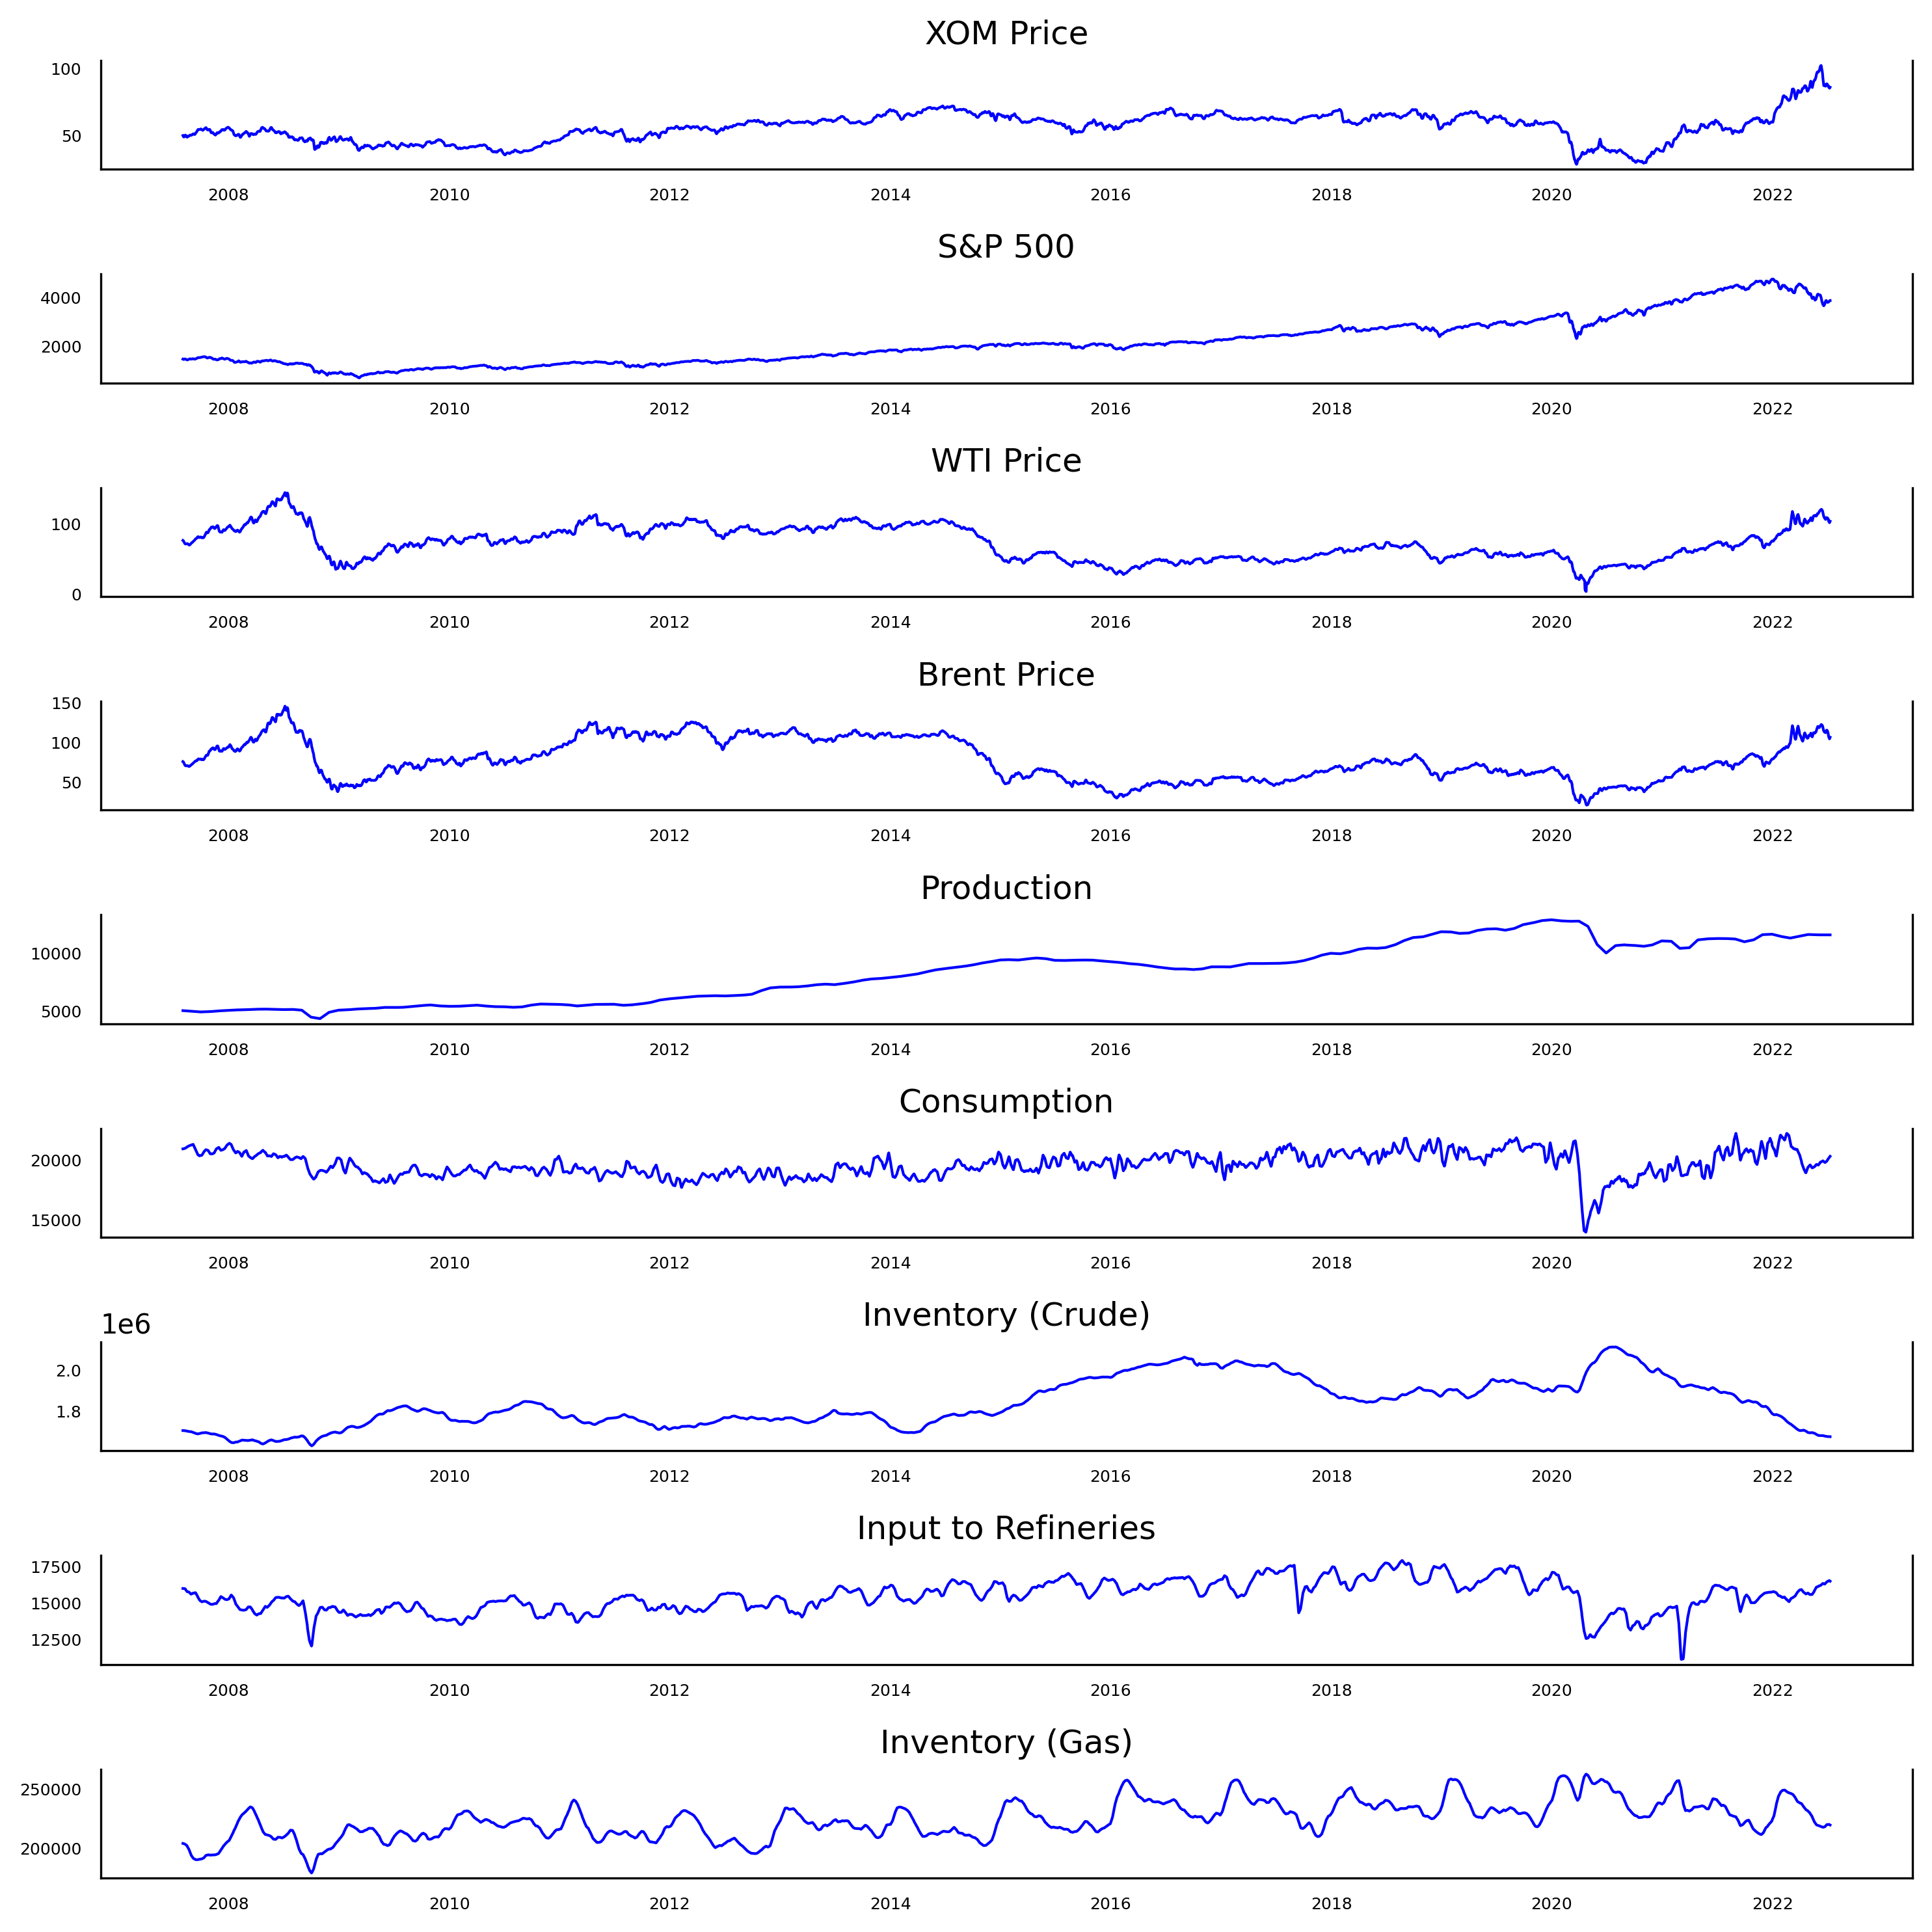

In [14]:
# Now let's visualize the dataset

df = data
# Plot
fig, axes = plt.subplots(nrows=9, ncols=1, dpi=300, figsize=(10,10))
for i, ax in enumerate(axes.flatten()):
    dat = df[df.columns[i]]
    ax.plot(dat, color='blue', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

As we can see from the images above, all the data looks non-stationary, except perhaps Inventory (Gas) or Input to Refineries. This is a problem in time series since non-stationary data has different means and variances over time, which make it impossible to model.
<br>
<br>We will deal with this problem later by differencing. First, let's test our hypothesis that the above time series data influences each other.

In [15]:
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(data, variables = df.columns)    

,XOM Price_x,S&P 500_x,WTI Price_x,Brent Price_x,Production_x,Consumption_x,Inventory (Crude)_x,Input to Refineries_x,Inventory (Gas)_x
XOM Price_y,1.0000,0.0000,0.0000,0.0000,0.0258,0.0001,0.0540,0.0000,0.0075
S&P 500_y,0.0000,1.0000,0.0000,0.0003,0.0005,0.0000,0.0000,0.0229,0.0015
WTI Price_y,0.0000,0.0000,1.0000,0.0000,0.0754,0.0000,0.0000,0.0000,0.0000
Brent Price_y,0.0000,0.0000,0.0000,1.0000,0.2137,0.1753,0.0001,0.0006,0.0000
Production_y,0.0000,0.0021,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000
Consumption_y,0.0000,0.0004,0.2582,0.2318,0.0007,1.0000,0.0000,0.0000,0.0000
Inventory (Crude)_y,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.2552,0.0000
Input to Refineries_y,0.0000,0.0169,0.0074,0.0185,0.0000,0.0265,0.0776,1.0000,0.0000
Inventory (Gas)_y,0.0719,0.0002,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000


As we can see above, most of the values in the matrix are under 0.05, which rejects the null hypothesis that any given X doesn't cause Y. What this means is that we can safely proceed with our assumption that the variables influence each other.

In [16]:
# Now let's convert data to float for usage in cointegration test

data = data.astype('float32')

In [17]:
def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(data)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
XOM Price ::  408.1     > 179.5199  =>   True
S&P 500 ::  284.53    > 143.6691  =>   True
WTI Price ::  170.99    > 111.7797  =>   True
Brent Price ::  97.88     > 83.9383   =>   True
Production ::  45.39     > 60.0627   =>   False
Consumption ::  23.41     > 40.1749   =>   False
Inventory (Crude) ::  12.43     > 24.2761   =>   False
Input to Refineries ::  3.76      > 12.3212   =>   False
Inventory (Gas) ::  0.13      > 4.1296    =>   False


Above, we can see that all the financial data is cointegrated, which essentially means that they follow similar trends and patterns, which is expected for financially traded products.

Let's go ahead and start taking our train and test sets to build our model down the line.

In [18]:
nobs = 10
df_train, df_test = data[0:-nobs], data[-nobs:]

# Check size
print(df_train.shape)
print(df_test.shape)

(5447, 9)
(10, 9)


Now let's go ahead and run our ADF (Dickey Fuller) test to see if the data is stationary

In [19]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.") 

In [20]:
for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "XOM Price" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.4526
 No. Lags Chosen       = 33
 Critical value 1%     = -3.432
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.5568. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "S&P 500" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = 0.2146
 No. Lags Chosen       = 33
 Critical value 1%     = -3.432
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.9731. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "WTI Price" 
    -----------------------------------------------
 Null Hypothesis: Da

We can see from the above that most data is non-stationary, except, as we suspected, Inventory (Gas) and Input to Refineries.
<br>
<br>What we need to do next is to "difference" the data, essentially to subtract the previous value to every value and run the ADF test again

In [21]:
df_differenced = df_train.diff().dropna()

In [22]:
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "XOM Price" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -12.1668
 No. Lags Chosen       = 33
 Critical value 1%     = -3.432
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "S&P 500" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -13.2921
 No. Lags Chosen       = 33
 Critical value 1%     = -3.432
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "WTI Price" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance

Fortunately, we can see that all data is now stationary!

Now let's start developing our model

In [23]:
model = VAR(df_differenced)
for i in [1,2,3,4,5,6,7,8,9]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  27.958828799069597
BIC :  28.067960254199633
FPE :  1387922077401.6213
HQIC:  27.99691301061531 

Lag Order = 2
AIC :  27.86844139763906
BIC :  28.07582348088757
FPE :  1267974235473.497
HQIC:  27.940813349953814 

Lag Order = 3
AIC :  27.816793156241218
BIC :  28.122456501074108
FPE :  1204148715499.3228
HQIC:  27.923464176801335 

Lag Order = 4
AIC :  27.7030437771477
BIC :  28.107019032410705
FPE :  1074681723959.9456
HQIC:  27.84402519928275 

Lag Order = 5
AIC :  27.414942929656476
BIC :  27.917260759585748
FPE :  805675228131.1217
HQIC:  27.590246092553386 

Lag Order = 6
AIC :  26.747141379749063
BIC :  27.347832463981735
FPE :  413179343270.17303
HQIC:  26.956777628456212 

Lag Order = 7
AIC :  26.578815515947685
BIC :  27.277910549532464
FPE :  349170190499.96454
HQIC:  26.822796201379017 

Lag Order = 8
AIC :  25.78281566857827
BIC :  26.58034536198603
FPE :  157521876606.0499
HQIC:  26.061152147517394 

Lag Order = 9
AIC :  25.59388515996957
BIC :  26.48

In [24]:
x = model.select_order(maxlags=12)
x.summary()

,AIC,BIC,FPE,HQIC
0,42.63,42.64,3.265e+18,42.63
1,27.97,28.08,1.399e+12,28.00
2,27.87,28.08,1.276e+12,27.95
3,27.82,28.13,1.211e+12,27.93
4,27.71,28.11,1.080e+12,27.85
5,27.42,27.92,8.104e+11,27.60
6,26.75,27.35,4.157e+11,26.96
7,26.58,27.28,3.509e+11,26.83
8,25.79,26.59,1.583e+11,26.07
9,25.60,26.49,1.309e+11,25.91


From the above, we select 12 as both AIC and FPE are lowest at that lag. We could continue going further in lags but since BIC has it's lowest at 11 and so does HQIC, we can stop at 12.

Now let's fit the model

In [25]:
model_fitted = model.fit(12)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 11, Jul, 2022
Time:                     15:58:53
--------------------------------------------------------------------
No. of Equations:         9.00000    BIC:                    26.3549
Nobs:                     5434.00    HQIC:                   25.5792
Log likelihood:          -136782.    FPE:                8.47814e+10
AIC:                      25.1633    Det(Omega_mle):     7.09044e+10
--------------------------------------------------------------------
Results for equation XOM Price
                             coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------------
const                           0.001892         0.002289            0.827           0.409
L1.XOM Price                    0.949817         0.018424           51.554           0.000
L1.S&P 500      

In [26]:
out = durbin_watson(model_fitted.resid)

for col, val in zip(df.columns, out):
    print((col), ':', round(val, 2))

XOM Price : 2.0
S&P 500 : 2.0
WTI Price : 2.0
Brent Price : 2.0
Production : 2.0
Consumption : 2.02
Inventory (Crude) : 2.0
Input to Refineries : 2.01
Inventory (Gas) : 2.0


Above we did the Durbin Watson test just to check if there was any pattern or trend left in the residuals, if there was, we would like to integrate it to the model.
<br>
<br>As we can see though, the numbers are very close to 2, as a rule of thumb that's about an ideal number reflecting the lack of trend in the residuals, so our model is robust.

In [27]:
# Get the lag order
lag_order = model_fitted.k_ar

# Input data for forecasting
forecast_input = df_differenced.values[-lag_order:]

Now let's forecast!

In [28]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df.index[-nobs:], columns=df.columns + '_1d')
df_forecast.tail()

Date,XOM Price_1d,S&P 500_1d,WTI Price_1d,Brent Price_1d,Production_1d,Consumption_1d,Inventory (Crude)_1d,Input to Refineries_1d,Inventory (Gas)_1d
2022-07-07,0.176424,-0.708703,-0.337607,-0.131467,0.495962,23.060700,-171.692873,-9.471728,131.844563
2022-07-08,0.070750,-1.165598,-0.312161,-0.172064,1.008245,8.530382,-194.185430,-10.658910,-11.705947
2022-07-09,-0.108232,4.697368,-0.363145,-0.327118,1.336129,13.555233,-193.499424,-7.019800,-1.471397
2022-07-10,-0.161188,4.420101,-0.218739,-0.295813,1.301529,8.206153,-186.493010,-10.565749,12.008331
2022-07-11,-0.237084,0.426255,0.084464,-0.129360,0.534866,8.198310,-178.241734,-14.627883,-27.959281


Remember that our data is differenced, so we'll need to revert it back:

In [29]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [30]:
df_results = invert_transformation(df_train, df_forecast, second_diff=False)

Now we can plot it, we can see that most of our predictions closely match the test set, which indicates that we have a strong model, let's look at the performance metrics in the bottom to confirm our suspicions.

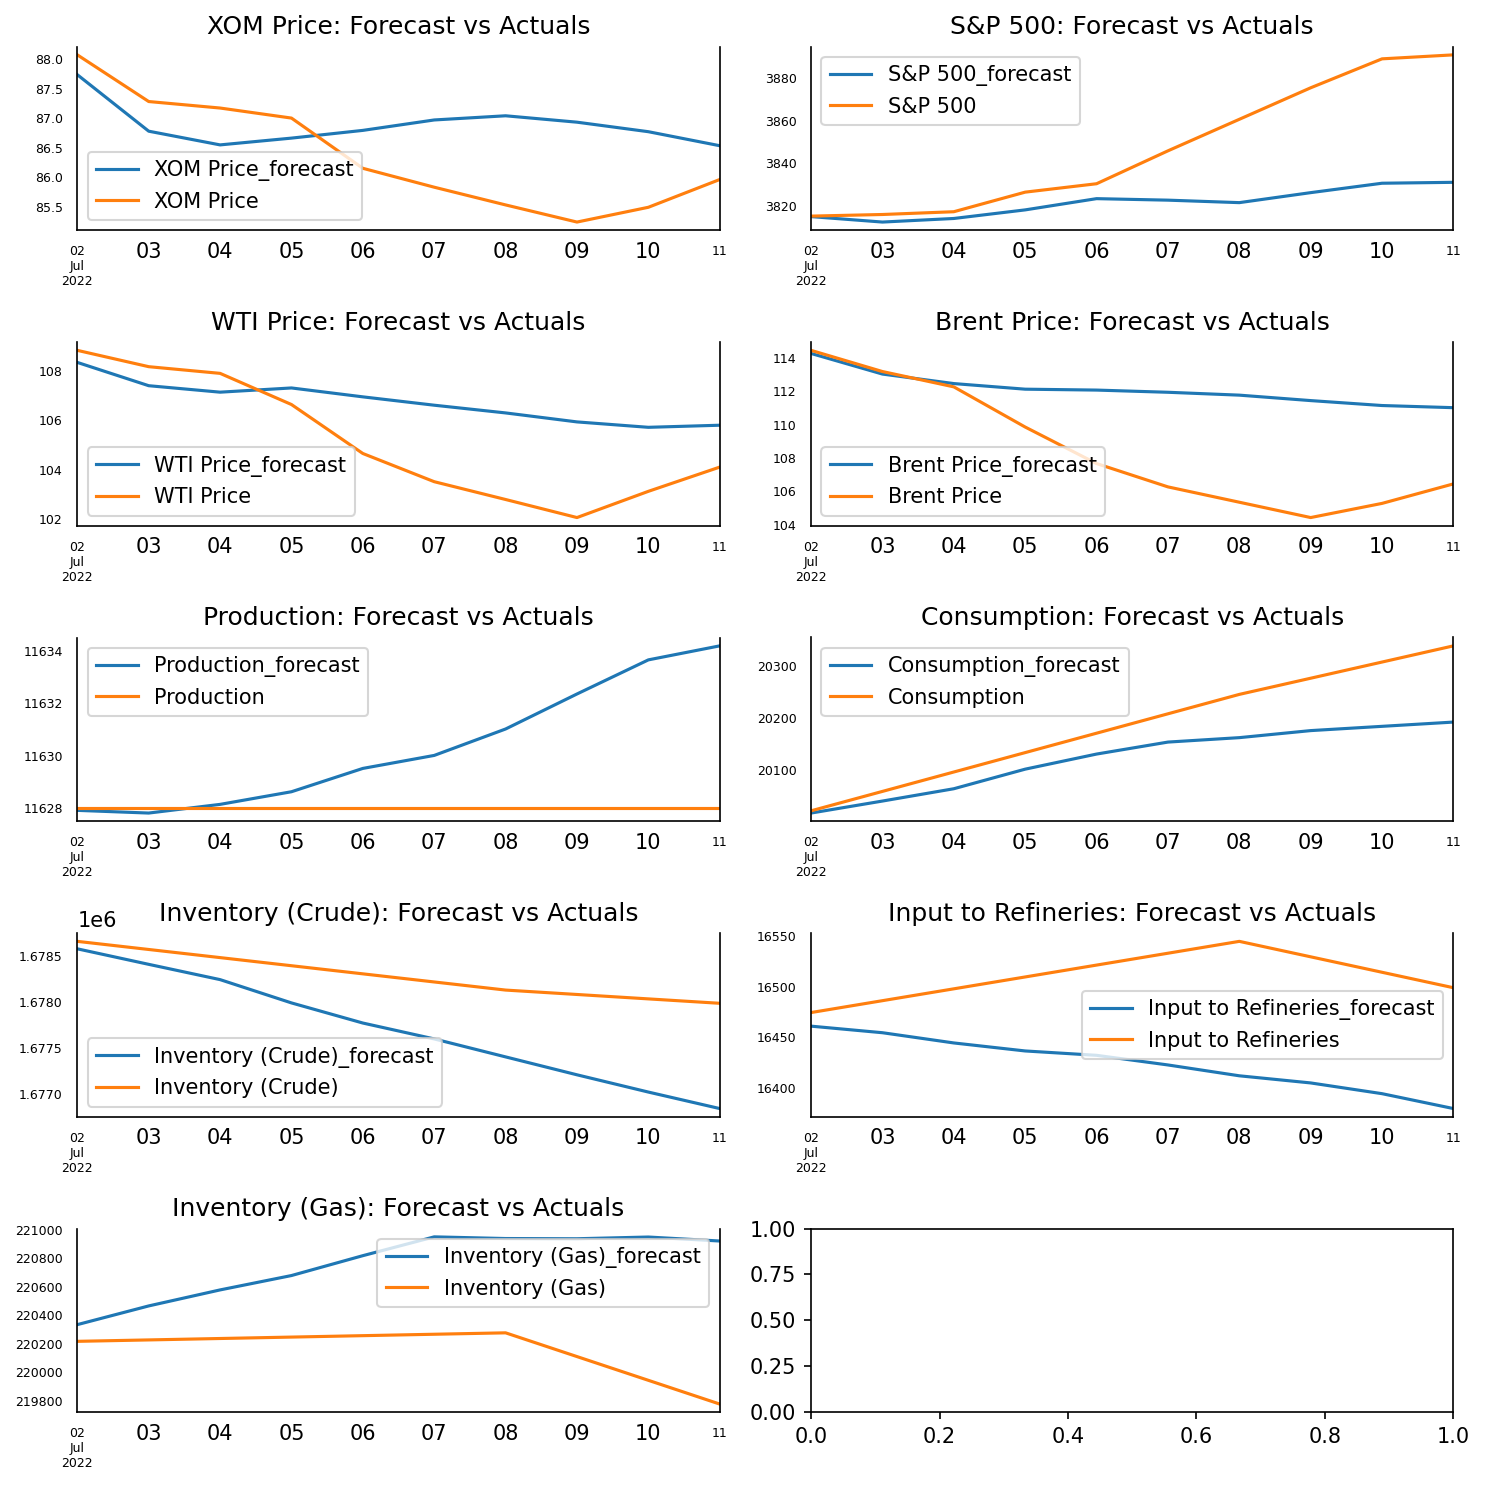

In [31]:
fig, axes = plt.subplots(nrows=5,ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [32]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

In [33]:
print('Forecast Accuracy of: XOM')
accuracy_prod = forecast_accuracy(df_results['XOM Price_forecast'].values, df_test['XOM Price'])
for k, v in accuracy_prod.items():
    print((k), ': ', round(v,4))

Forecast Accuracy of: XOM
mape :  0.01
me :  0.5029
mae :  0.8632
mpe :  0.0059
rmse :  0.9836
corr :  0.332
minmax :  0.0099


C:\Users\reneg\AppData\Local\Temp/ipykernel_27140/2363812276.py:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)
C:\Users\reneg\AppData\Local\Temp/ipykernel_27140/2363812276.py:11: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)


In [34]:
print('Forecast Accuracy of: S&P 500')
accuracy_prod = forecast_accuracy(df_results['S&P 500_forecast'].values, df_test['S&P 500'])
for k, v in accuracy_prod.items():
    print((k), ': ', round(v,4))

Forecast Accuracy of: S&P 500
mape :  0.0065
me :  -25.2207
mae :  25.2207
mpe :  -0.0065
rmse :  34.1162
corr :  0.9351
minmax :  0.0065


C:\Users\reneg\AppData\Local\Temp/ipykernel_27140/2363812276.py:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)
C:\Users\reneg\AppData\Local\Temp/ipykernel_27140/2363812276.py:11: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)


In [35]:
print('Forecast Accuracy of: WTI')
accuracy_prod = forecast_accuracy(df_results['WTI Price_forecast'].values, df_test['WTI Price'])
for k, v in accuracy_prod.items():
    print((k), ': ', round(v,4))

Forecast Accuracy of: WTI
mape :  0.019
me :  1.5685
mae :  1.9719
mpe :  0.0153
rmse :  2.3117
corr :  0.8811
minmax :  0.0185


C:\Users\reneg\AppData\Local\Temp/ipykernel_27140/2363812276.py:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)
C:\Users\reneg\AppData\Local\Temp/ipykernel_27140/2363812276.py:11: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)


In [36]:
print('Forecast Accuracy of: Brent')
accuracy_prod = forecast_accuracy(df_results['Brent Price_forecast'].values, df_test['Brent Price'])
for k, v in accuracy_prod.items():
    print((k), ': ', round(v,4))

Forecast Accuracy of: Brent
mape :  0.0347
me :  3.6096
mae :  3.6772
mpe :  0.0341
rmse :  4.5027
corr :  0.8863
minmax :  0.0329


C:\Users\reneg\AppData\Local\Temp/ipykernel_27140/2363812276.py:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)
C:\Users\reneg\AppData\Local\Temp/ipykernel_27140/2363812276.py:11: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)


In [37]:
print('Forecast Accuracy of: Production')
accuracy_prod = forecast_accuracy(df_results['Production_forecast'].values, df_test['Production'])
for k, v in accuracy_prod.items():
    print((k), ': ', round(v,4))

Forecast Accuracy of: Production


C:\Users\reneg\anaconda3\envs\ds22\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\reneg\anaconda3\envs\ds22\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\reneg\AppData\Local\Temp/ipykernel_27140/2363812276.py:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)
C:\Users\reneg\AppData\Local\Temp/ipykernel_27140/2363812276.py:11: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)


mape :  0.0002
me :  2.3248
mae :  2.3794
mpe :  0.0002
rmse :  3.2441
corr :  nan
minmax :  0.0002


In [38]:
print('Forecast Accuracy of: Consumption')
accuracy_prod = forecast_accuracy(df_results['Consumption_forecast'].values, df_test['Consumption'])
for k, v in accuracy_prod.items():
    print((k), ': ', round(v,4))

Forecast Accuracy of: Consumption
mape :  0.0031
me :  -63.5876
mae :  63.5876
mpe :  -0.0031
rmse :  78.0289
corr :  0.9803
minmax :  0.0031


C:\Users\reneg\AppData\Local\Temp/ipykernel_27140/2363812276.py:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)
C:\Users\reneg\AppData\Local\Temp/ipykernel_27140/2363812276.py:11: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)


In [39]:
print('Forecast Accuracy of: Inventory (Crude)')
accuracy_prod = forecast_accuracy(df_results['Inventory (Crude)_forecast'].values, df_test['Inventory (Crude)'])
for k, v in accuracy_prod.items():
    print((k), ': ', round(v,4))

Forecast Accuracy of: Inventory (Crude)
mape :  0.0003
me :  -576.2282
mae :  576.2282
mpe :  -0.0003
rmse :  670.3588
corr :  0.9947
minmax :  0.0003


C:\Users\reneg\AppData\Local\Temp/ipykernel_27140/2363812276.py:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)
C:\Users\reneg\AppData\Local\Temp/ipykernel_27140/2363812276.py:11: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)


In [40]:
print('Forecast Accuracy of: Input to Refineries')
accuracy_prod = forecast_accuracy(df_results['Input to Refineries_forecast'].values, df_test['Input to Refineries'])
for k, v in accuracy_prod.items():
    print((k), ': ', round(v,4))

Forecast Accuracy of: Input to Refineries
mape :  0.0052
me :  -86.3803
mae :  86.3803
mpe :  -0.0052
rmse :  95.1065
corr :  -0.5077
minmax :  0.0052


C:\Users\reneg\AppData\Local\Temp/ipykernel_27140/2363812276.py:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)
C:\Users\reneg\AppData\Local\Temp/ipykernel_27140/2363812276.py:11: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)


In [41]:
print('Forecast Accuracy of: Inventory (Gas)')
accuracy_prod = forecast_accuracy(df_results['Inventory (Gas)_forecast'].values, df_test['Inventory (Gas)'])
for k, v in accuracy_prod.items():
    print((k), ': ', round(v,4))

Forecast Accuracy of: Inventory (Gas)
mape :  0.0027
me :  600.4528
mae :  600.4528
mpe :  0.0027
rmse :  677.2266
corr :  -0.3769
minmax :  0.0027


C:\Users\reneg\AppData\Local\Temp/ipykernel_27140/2363812276.py:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)
C:\Users\reneg\AppData\Local\Temp/ipykernel_27140/2363812276.py:11: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)


As a rule of thumb, a MAPE less than 10% represents an excellent model.

In [42]:
data

Date,XOM Price,S&P 500,WTI Price,Brent Price,Production,Consumption,Inventory (Crude),Input to Refineries,Inventory (Gas)
2007-08-03,49.880001,1460.050049,76.779999,75.730003,5050.629883,20962.130859,1707742.125,16001.000000,204331.671875
2007-08-04,49.419998,1451.880005,76.510002,75.529999,5048.879883,20967.730469,1707684.500,15998.929688,204255.875000
2007-08-05,49.060001,1447.439941,75.970001,75.070000,5047.129883,20973.330078,1707626.875,15996.870117,204180.062500
2007-08-06,48.790001,1447.810059,75.070000,74.239998,5045.379883,20978.929688,1707569.375,15994.799805,204104.265625
2007-08-07,48.849998,1448.709961,74.180000,73.440002,5043.629883,20984.529297,1707511.750,15992.730469,204028.468750
...,...,...,...,...,...,...,...,...,...
2022-07-07,85.830002,3845.949951,103.519997,106.269997,11628.000000,20208.730469,1678215.875,16532.730469,220266.875000
2022-07-08,85.529999,3860.760010,102.800003,105.349998,11628.000000,20246.070312,1678128.250,16544.400391,220276.796875
2022-07-09,85.239998,3875.570068,102.070000,104.430000,11628.000000,20277.199219,1678080.625,16529.199219,220110.406250
2022-07-10,85.489998,3889.169922,103.129997,105.279999,11628.000000,20308.330078,1678033.000,16514.000000,219944.000000


#### Now let's predict into the future

We are now using the whole dataset (we difference it) to feed the model with 12 lags (as predetermined)

In [43]:
# Difference all the dataset

data_diff = data.diff().dropna()

In [44]:
data_diff

Date,XOM Price,S&P 500,WTI Price,Brent Price,Production,Consumption,Inventory (Crude),Input to Refineries,Inventory (Gas)
2007-08-04,-0.460003,-8.170044,-0.269997,-0.200005,-1.75,5.599609,-57.625,-2.070312,-75.796875
2007-08-05,-0.359997,-4.440063,-0.540001,-0.459999,-1.75,5.599609,-57.625,-2.059570,-75.812500
2007-08-06,-0.270000,0.370117,-0.900002,-0.830002,-1.75,5.599609,-57.500,-2.070312,-75.796875
2007-08-07,0.059998,0.899902,-0.889999,-0.799995,-1.75,5.599609,-57.625,-2.069336,-75.796875
2007-08-08,0.680000,12.890015,-0.660004,-0.750000,-1.75,5.601562,-57.625,-2.060547,-75.796875
...,...,...,...,...,...,...,...,...,...
2022-07-07,-0.320000,15.459961,-1.140007,-1.400002,0.00,37.330078,-87.750,11.660156,9.937500
2022-07-08,-0.300003,14.810059,-0.719994,-0.919998,0.00,37.339844,-87.625,11.669922,9.921875
2022-07-09,-0.290001,14.810059,-0.730003,-0.919998,0.00,31.128906,-47.625,-15.201172,-166.390625
2022-07-10,0.250000,13.599854,1.059998,0.849998,0.00,31.130859,-47.625,-15.199219,-166.406250


In [45]:
#make final predictions
model = VAR(data_diff)

We select 10 steps (days) for our prediction

In [46]:
steps = 10

model_fit = model.fit(12)

pred = model_fit.forecast(data_diff.values[-model_fit.k_ar:], steps=steps)

In [47]:
pred_df = pd.DataFrame(pred,columns=['XOM Price',
             'S&P 500',
             'WTI Price',
             'Brent Price',
             'Production',
             'Consumption',
             'Inventory (Crude)',
             'Input to Refineries',
             'Inventory (Gas)'])
pred_df.index = pd.date_range(start=data_diff.index[-1], periods=steps+1)[1:]

In [48]:
def diff_inv(series_diff, first_value):
    series_inverted = np.r_[first_value, series_diff].cumsum().astype('float64')
    return series_inverted

What we are doing here is inverting the differenced predictions, we use the last data point from the original dataset as a basis

In [49]:
pred1 = diff_inv(pred_df['XOM Price'], data['XOM Price'].tail(1))
pred_df['XOM Price'] = pred1[1:steps+1]
pred2 = diff_inv(pred_df['S&P 500'], data['S&P 500'].tail(1))
pred_df['S&P 500'] = pred2[1:steps+1]
pred3 = diff_inv(pred_df['WTI Price'], data['WTI Price'].tail(1))
pred_df['WTI Price'] = pred3[1:steps+1]
pred4 = diff_inv(pred_df['Brent Price'], data['Brent Price'].tail(1))
pred_df['Brent Price'] = pred4[1:steps+1]
pred5 = diff_inv(pred_df['Production'], data['Production'].tail(1))
pred_df['Production'] = pred5[1:steps+1]
pred6 = diff_inv(pred_df['Consumption'], data['Consumption'].tail(1))
pred_df['Consumption'] = pred6[1:steps+1]
pred7 = diff_inv(pred_df['Inventory (Crude)'], data['Inventory (Crude)'].tail(1))
pred_df['Inventory (Crude)'] = pred7[1:steps+1]
pred8 = diff_inv(pred_df['Input to Refineries'], data['Input to Refineries'].tail(1))
pred_df['Input to Refineries'] = pred8[1:steps+1]
pred9 = diff_inv(pred_df['Inventory (Gas)'], data['Inventory (Gas)'].tail(1))
pred_df['Inventory (Gas)'] = pred9[1:steps+1]

In [50]:
pred_df = pred_df.round(decimals = 2)

In [51]:
pred_df

,XOM Price,S&P 500,WTI Price,Brent Price,Production,Consumption,Inventory (Crude),Input to Refineries,Inventory (Gas)
2022-07-12,86.32,3891.45,104.96,107.38,11628.79,20372.87,1677847.83,16485.11,219608.89
2022-07-13,86.74,3884.14,105.62,108.22,11629.66,20383.65,1677799.19,16474.92,219480.98
2022-07-14,86.98,3876.87,106.23,109.07,11630.02,20390.66,1677787.08,16459.84,219349.89
2022-07-15,86.91,3867.21,106.06,109.30,11630.89,20386.91,1677761.72,16441.96,219212.36
2022-07-16,87.02,3867.18,106.34,109.45,11632.08,20372.08,1677753.47,16430.00,218999.92
2022-07-17,87.00,3862.14,106.32,109.46,11633.32,20358.57,1677737.77,16417.52,218786.78
2022-07-18,86.96,3862.75,106.30,109.40,11634.43,20345.81,1677723.11,16405.03,218569.68
2022-07-19,87.02,3863.39,106.18,109.28,11635.97,20327.23,1677682.94,16393.17,218355.93
2022-07-20,87.05,3864.24,105.93,108.94,11637.72,20320.41,1677677.01,16379.99,218161.48
2022-07-21,86.88,3864.34,105.41,108.47,11640.08,20311.35,1677700.00,16366.80,217952.92


In [52]:
df = data.tail(100).copy()
fc = pred_df.copy()
dp = 'XOM Price'

We observe that the forecast has a shape and a unique trend, which indicates that it's taking information to make the prediction. Much like we observed in the test vs forecast images earlier, the model seems to learn enough information from every time series to inform each unique time series forecast.
<br>
<br>The variable selection and VAR model seem to have a robust performance in predicting the Exxon stock price in the short term.
<br>Some future considerations would be to add time series sets and/or combine them for dimensionality reduction. 
<br>
<br>Further, it would be interesting to compare the model performance with some deep learning algorithms like LSTM or perhaps, with a simpler univariate time series model like SARIMA.

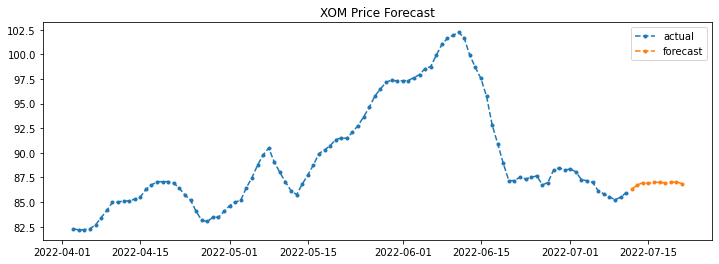

In [53]:
plt.figure(figsize=(12,4))
plt.plot(df.index, df[dp], label='actual',linestyle='dashed', marker='.')
plt.plot(fc.index, fc[[dp]], label='forecast',linestyle='dashed', marker='.')
plt.title(f"{dp} Forecast")
# plt.ylim(0.0,0.9)
plt.legend();

Use Case: This model could be used for simple short-term investment strategies. 
<br>For example, based on the above forecast, we could buy Exxon stock, to then in turn sell it on day 10.

References:

https://www.eia.gov/petroleum/data.php
<br>https://medium.com/analytics-vidhya/use-python-to-pull-energy-data-from-the-us-department-of-energys-api-11d6f724927e
<br>https://github.com/shuzlee/EIA-Runs/blob/master/Crude%20Runs.ipynb
<br>https://pandas.pydata.org/
<br>www.statsmodels.org
<br>www.stackoverflow.com
<br>https://docs.digitalearthafrica.org/en/latest/sandbox/notebooks/Use_cases/Okavango/6_Forecasting_water_extent.html
<br>https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/